In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator, img_to_array
import numpy as np
import os
import json
import zipfile
%pip install mlflow
import mlflow
from urllib.parse import urlparse
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import gdown


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.3 MB/s eta 0:00:00


In [2]:
try:
  dataset_url = "https://drive.google.com/file/d/14znbD39vcuImCFJ7DqUgz9x63ytWwjHI/view?usp=sharing"
  zip_download_dir =  "content/"
  file_id = dataset_url.split("/")[-2]
  prefix = "https://drive.google.com/uc?/export=download&id="
  gdown.download(prefix + file_id, zip_download_dir)

except Exception as e:
  raise e

Downloading...
From (original): https://drive.google.com/uc?/export=download&id=14znbD39vcuImCFJ7DqUgz9x63ytWwjHI
From (redirected): https://drive.google.com/uc?%2Fexport=download&id=14znbD39vcuImCFJ7DqUgz9x63ytWwjHI&confirm=t&uuid=2773d16b-baef-4a23-9f46-cf7d65d75009
To: /content/content/dataset.zip
100%|██████████| 127M/127M [00:00<00:00, 240MB/s]


In [3]:
try:
  with zipfile.ZipFile('content/dataset.zip', "r") as zip_ref:
      zip_ref.extractall('content/')

except Exception as e:
  raise e

In [12]:
params = {
    "LEARNING_RATE": 0.01,
    "CLASSES": 2,
    "EPOCHS": 30,
    "BATCH_SIZE": 80,
    "IMAGE_SIZE": [224, 224, 3],
}

In [6]:
data = 'content/dataset/train'

In [7]:
# mlflow configs
MLFLOW_TRACKING_URI = "https://dagshub.com/kalema3502/MIIA-Pothole-Image-classification.mlflow"
MLFLOW_TRACKING_USERNAME = "kalema3502"
MLFLOW_TRACKING_PASSWORD = "fb3845efcc3b2e46a4157b1d2c977a21e02dd16e"

In [8]:
# Define data generator for training data with augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    directory=data,
    target_size=params['IMAGE_SIZE'][:-1],
    batch_size=params['BATCH_SIZE'],
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    directory=data,
    target_size=params['IMAGE_SIZE'][:-1],
    batch_size=params['BATCH_SIZE'],
    class_mode='categorical',
    subset='validation'
)

Found 576 images belonging to 2 classes.
Found 144 images belonging to 2 classes.


In [9]:
import tensorflow as tf
from tensorflow import keras
%pip install keras-tuner
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

def build_model(hp):
    model = Sequential()

    # Add Conv2D layers with hyperparameter search for filters
    model.add(Conv2D(
        filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(224, 224, 3)
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(
        filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(
        filters=hp.Int('conv3_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(
        filters=hp.Int('conv4_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    # Add Dense layer with hyperparameter search for units
    model.add(Dense(
        units=hp.Int('dense_units', min_value=128, max_value=512, step=64),
        activation='relu'
    ))

    # Output layer with softmax activation
    model.add(Dense(params['CLASSES'], activation='softmax'))

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Define hyperparameter search space
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    directory='content/',
    project_name='pothole_classification'
)

tuner.search(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(best_hps)

Trial 10 Complete [00h 01m 16s]
val_loss: 0.1008424237370491

Best val_loss So Far: 0.04479743912816048
Total elapsed time: 00h 15m 10s


In [10]:
conv1_filters = 64
conv2_filters = 128
conv3_filters = 96
conv4_filters = 64
dense_units = 320

# Create the model
model = Sequential([
    Conv2D(conv1_filters, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(conv2_filters, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(conv3_filters, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(conv4_filters, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(dense_units, activation='relu'),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 96)        110688    
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 26, 26, 96)       

In [13]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

os.makedirs('artifacts/', exist_ok=True)

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=1e-5)

checkpoint = ModelCheckpoint(filepath='artifacts/model.h5',
                             verbose=1,
                             save_best_only=True)

callbacks = [checkpoint, lr_reducer]
start = datetime.now()

model.fit_generator(generator=train_generator,
                        validation_data=validation_generator,
                        epochs=params['EPOCHS'],
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=validation_steps,
                        callbacks=callbacks,
                        verbose=1)

<ipython-input-13-07cb309ad50e>:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator,


Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 0.1361 - accuracy: 0.9496
Epoch 1: val_loss improved from inf to 0.07428, saving model to artifacts/model.h5
7/7 [==============================] - 4s 613ms/step - loss: 0.1361 - accuracy: 0.9496 - val_loss: 0.0743 - val_accuracy: 0.9875 - lr: 3.1623e-04
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 0.1355 - accuracy: 0.9577
Epoch 2: val_loss did not improve from 0.07428
7/7 [==============================] - 3s 417ms/step - loss: 0.1355 - accuracy: 0.9577 - val_loss: 0.0994 - val_accuracy: 0.9750 - lr: 3.1623e-04
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 0.1412 - accuracy: 0.9456
Epoch 3: val_loss did not improve from 0.07428
7/7 [==============================] - 3s 497ms/step - loss: 0.1412 - accuracy: 0.9456 - val_loss: 0.0990 - val_accuracy: 0.9750 - lr: 3.1623e-04
Epoch 4/30
7/7 [==============================] - ETA: 0s - loss: 0.1063 - accuracy: 0.9657
Epoch 4: val_loss

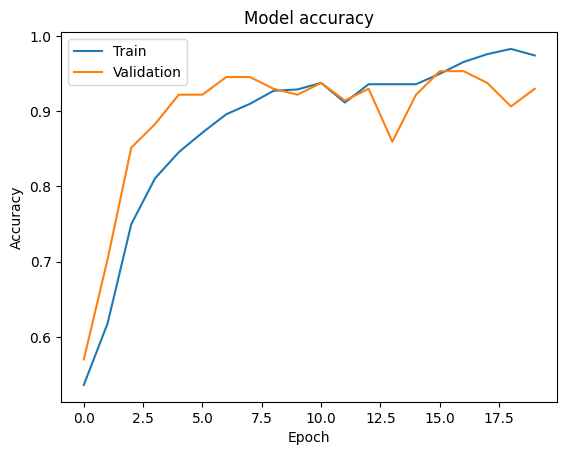

In [ ]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png')
plt.show()

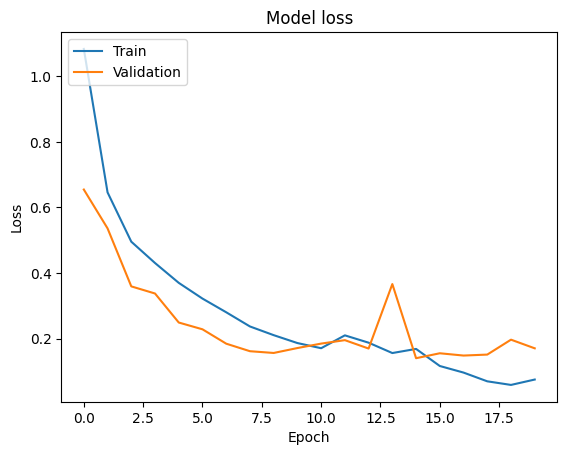

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png')
plt.show()

In [14]:
  # model evaluation
best_model = load_model('artifacts/model.h5')

results = best_model.evaluate(validation_generator)

scores = {'loss': results[0], 'accuracy': results[1]}

try:
    with open('scores.json', 'w') as json_file:
        json.dump(scores, json_file)
except IOError as e:
    raise IOError(f"An error occurred while writing to the file: {e}")

2/2 [==============================] - 1s 264ms/step - loss: 0.0792 - accuracy: 0.9722


In [15]:
# mlflow configs
os.environ["MLFLOW_TRACKING_URI"]= MLFLOW_TRACKING_URI
os.environ["MLFLOW_TRACKING_USERNAME"]= MLFLOW_TRACKING_USERNAME
os.environ["MLFLOW_TRACKING_PASSWORD"]= MLFLOW_TRACKING_PASSWORD

In [16]:
# experiment tracking
mlflow.set_registry_uri(MLFLOW_TRACKING_URI)
tracking_url_type_store= urlparse(mlflow.get_tracking_uri()).scheme

with mlflow.start_run():
    mlflow.log_params(params)
    mlflow.log_metrics(
        {"loss": results[0], "accuracy": results[1]}
    )

    if tracking_url_type_store != "file":
        mlflow.keras.log_model(best_model, "model", registered_model_name="CustomModel")
    else:
        mlflow.keras.log_model(best_model, "model")

2024/04/27 19:01:25 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'CustomModel' already exists. Creating a new version of this model...
2024/04/27 19:02:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: CustomModel, version 10
Created version '10' of model 'CustomModel'.


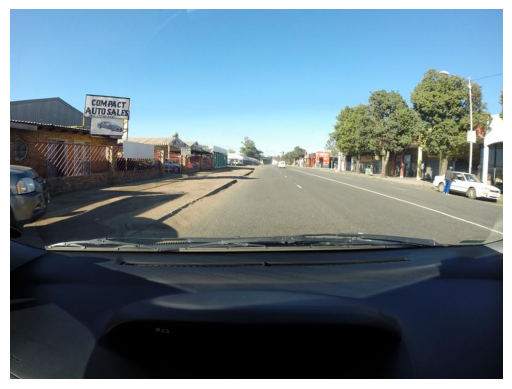

1/1 [==============================] - 0s 474ms/step
Top Label: No Pothole
score: [0.73099643 0.2690036 ]


In [17]:
%pip install opencv-python
import cv2
image = cv2.imread('/content/content/dataset/test/EEqfXYxntAQFLju.JPG')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()
# Preprocess the image
image = cv2.resize(image, (224, 224))
image = image.astype('float32') / 255
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

# Define the prediction function
def prediction_function(image):
    best_model = load_model('artifacts/model.h5')
    return best_model.predict(image)

# explainer = lime_image.LimeImageExplainer()

predictions = prediction_function(image)

class_names = ['No Pothole', 'Has Pothole']
score = tf.nn.softmax(predictions[0])
print(f"Top Label: {class_names[np.argmax(score)]}")
print(f"score: {score}")

In [18]:

test_dir = '/content/content/dataset/test/'

submission_data = {'Image_ID': [], 'Label': []}

for image_file in os.listdir(test_dir):
    image_path = os.path.join(test_dir, image_file)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = image.astype('float32') / 255
    image = np.expand_dims(image, axis=0)

    predictions = prediction_function(image)
    probability_class_1 = predictions[0][1]

    submission_data['Image_ID'].append(image_file.split('.')[0])
    submission_data['Label'].append(probability_class_1)

submission_df = pd.DataFrame(submission_data)

submission_df.to_csv('submission.csv', index=False)

1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 0s 136ms/step


1/1 [==============================] - 0s 78ms/step
